## PLEASE RUN FROM THE TOP

In [273]:
import pandas as pd
import seaborn as sns

# Load the excel file into a DataFrame
df = pd.read_excel('vaccine_city_sex.xlsx', engine='openpyxl')

# Display the first few rows of the DataFrame
df.head()

,date,county,city,gender,population,atleast_onedose,fully_vaccinated,boosted_after_2022-09-01,boosted,boosted_second,partially_vaccinated
0,2021-03-09,Barnstable,Barnstable,Female,23171.0,7280.0,3798.0,NaN,NaN,NaN,3482.0
1,2021-03-09,Barnstable,Barnstable,Male,21601.0,4895.0,2239.0,NaN,NaN,NaN,2656.0
2,2021-03-09,Barnstable,Barnstable,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-03-09,Barnstable,Barnstable,Total,44773.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-03-09,Barnstable,Bourne,Female,9945.0,3394.0,1631.0,NaN,NaN,NaN,1763.0


In [274]:
vac_data = pd.read_excel('vaccine_city_sex.xlsx', engine='openpyxl')

In [275]:
cities_of_interest = ['Revere', 'Chelsea', 'Newton', 'Wellesley', 'New Bedford']
vac_data = vac_data[vac_data['city'].isin(cities_of_interest)]

vac_data['fully_vac_rate'] = round((vac_data['fully_vaccinated'] / vac_data['population']),2) * 100
vac_data['partially_vac_rate'] = round((vac_data['partially_vaccinated'] / vac_data['population']),2) * 100
vac_data['onedose_vac_rate'] = round((vac_data['atleast_onedose'] / vac_data['population']),2) * 100
vac_data['boosted_rate'] = round((vac_data['boosted'] / vac_data['population']),2) * 100

In [276]:
import numpy as np
# Custom function to apply to each row
def check_vac(row):
    vaccination_columns = ["fully_vaccinated", "atleast_onedose", "boosted", "boosted_second", "partially_vaccinated"]
    for col in vaccination_columns:
        if row[col] > row["population"]:
            row[col] = np.nan
    return row
# Apply the function across the DataFrame row-wise
vac_data = vac_data.apply(check_vac, axis=1)

In [336]:
vac_data['year'] = vac_data['date'].dt.year
vac_data['month'] = vac_data['date'].dt.month
vac_data['year_month'] = vac_data['date'].dt.to_period('M')

#using the max population replace the missing population
vac_data['population'] = vac_data.groupby(['year','city','gender'])['population'].transform(lambda x: x.fillna(x.max()))

#using the max population replace the population
vac_data['population'] = vac_data.groupby(['year','city','gender'])['population'].transform(lambda x: x.max())

# print(vac_data.head(10))
# print(vac_data.shape)

In [335]:
filtered_df = vac_data[vac_data['gender'].isin(['Female', 'Male'])]
filtered_df = filtered_df[['year','month','city', 'gender', 'fully_vac_rate']]
filtered_data = filtered_df[(filtered_df['year'] == 2023) & (filtered_df['month'] == 4)]

# print(filtered_data)

In [334]:
# filtered_df = vac_data[vac_data['gender'].isin(['Female', 'Male'])]
# filtered_df = filtered_df[['city', 'gender', 'onedose_vac_rate']]
# filtered_df = filtered_df.drop_duplicates(subset=['city', 'gender'])

# # Pivoting the data for better visualization
# pivot_df = filtered_df.pivot(index='city', columns='gender', values='onedose_vac_rate')

# # Plotting
# plt.figure(figsize=(8, 6))
# pivot_df.plot(kind='bar', color=['pink', 'blue'], title="One Dose Vaccinated by Gender and City")
# plt.xticks(rotation=45, ha='right')
# plt.ylabel('One Dose Vaccinated Rate (%)')
# plt.xlabel('City')
# plt.tight_layout()
# plt.show()

In [207]:
filtered_df

,city,gender,fully_vac_rate
200,New Bedford,Female,9.0
201,New Bedford,Male,5.0
780,Newton,Female,19.0
781,Newton,Male,14.0
968,Wellesley,Female,12.0
969,Wellesley,Male,10.0
1096,Chelsea,Female,11.0
1097,Chelsea,Male,7.0
1100,Revere,Female,11.0
1101,Revere,Male,7.0


In [338]:
# 2. transform data into monthly data

# Group by 'year', 'month', 'city', and 'race' and then take the max
monthly_data = vac_data.drop(columns=['date'])
monthly_data = monthly_data.groupby(['year', 'month', 'city', 'gender']).max().reset_index()

print(len(monthly_data))

# monthly_data.head(10)

520


In [339]:
# 3. calculate the vaccination rate
# Calculating vaccination rate
monthly_data['fully_vac_rate'] = round((monthly_data['fully_vaccinated'] / monthly_data['population']),2) * 100
monthly_data['partially_vac_rate'] = round((monthly_data['partially_vaccinated'] / monthly_data['population']),2) * 100
monthly_data['onedose_vac_rate'] = round((monthly_data['atleast_onedose'] / monthly_data['population']),2) * 100
monthly_data['boosted_rate'] = round((monthly_data['boosted'] / monthly_data['population']),2) * 100

monthly_data = monthly_data[~monthly_data['gender'].isin(['Other'])]

monthly_data = monthly_data[~monthly_data['gender'].isin(['Total'])]
# monthly_data = monthly_data[~monthly_data['gender'].isin(['Male'])]


In [340]:
# 4. Adjusts the vaccination rates in the DataFrame such that they do not decrease compared to the previous time point.

def adjust_vac_rates_for_all_columns(df, city_col, race_col, time_col, vac_rate_cols):
    """
    Adjusts the vaccination rates in the DataFrame such that they do not decrease compared to the previous time point.

    :return: Modified DataFrame with adjusted vaccination rates.
    """
    # Iterate over each city and race
    for city in df[city_col].unique():
        for race in df[df[city_col] == city][race_col].unique():
            # Filter the data for the current city and race
            city_race_data = df[(df[city_col] == city) & (df[race_col] == race)].copy()
            # Sort by time to ensure chronological order
            city_race_data.sort_values(time_col, inplace=True)
            
            # Iterate over each vaccination rate column to apply the cummax adjustment
            for vac_rate_col in vac_rate_cols:
                city_race_data[vac_rate_col] = city_race_data[vac_rate_col].cummax()
            
            # Update the original DataFrame
            df.update(city_race_data)
    
    # Return the modified DataFrame
    return df

# Usage
vac_columns = ["fully_vac_rate", "onedose_vac_rate", "boosted_rate", "partially_vac_rate"]
monthly_data = adjust_vac_rates_for_all_columns(monthly_data, 'city', 'gender', 'year_month', vac_columns)


In [343]:
# Fillout the missing values with previous next value
def fill_missing_with_next(df, city_col, gender_col, time_col, vac_rate_cols):
    """
    Fills missing values in the vaccination rate columns with the next available non-NaN value.

    :param df: pandas DataFrame containing the data.
    :param vac_rate_cols: List of column names representing different vaccination rates.
    :return: DataFrame with missing values filled.
    """
    # Make a copy of the dataframe to avoid changing the original dataframe
    # Iterate over each city and race
    for city in df[city_col].unique():
        for race in df[df[city_col] == city][gender_col].unique():
            # Filter the data for the current city and race
            city_gender_data = df[(df[city_col] == city) & (df[gender_col] == race)].copy()
            # Sort by time to ensure chronological order
            city_gender_data.sort_values(time_col, inplace=True)
    
    # Iterate over each vaccination rate column and fill NaN values with the next non-NaN value
            for vac_rate_col in vac_rate_cols:
                city_gender_data[vac_rate_col] = city_gender_data[vac_rate_col].fillna(method='bfill')

            df.update(city_gender_data)
    # Update the original DataFrame
    return df

# Usage
vac_columns = ["fully_vac_rate", "onedose_vac_rate", "boosted_rate", "partially_vac_rate"]
monthly_data_filled = fill_missing_with_next(monthly_data, 'city', 'gender', 'year_month', vac_columns)


/var/folders/b1/s_2bdh751d7_gtrtwf3td9wc0000gn/T/ipykernel_72596/1836259686.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  city_gender_data[vac_rate_col] = city_gender_data[vac_rate_col].fillna(method='bfill')


In [344]:
selected_columns_2021_03 = monthly_data_filled[
    (monthly_data_filled['year_month'] == "2021-03")
][['city', 'fully_vac_rate', 'gender', 'year_month']]

# Display the selected columns
print(selected_columns_2021_03)

           city  fully_vac_rate  gender year_month
0       Chelsea            19.0  Female    2021-03
1       Chelsea            13.0    Male    2021-03
4   New Bedford            14.0  Female    2021-03
5   New Bedford             9.0    Male    2021-03
8        Newton            30.0  Female    2021-03
9        Newton            24.0    Male    2021-03
12       Revere            20.0  Female    2021-03
13       Revere            14.0    Male    2021-03
16    Wellesley            20.0  Female    2021-03
17    Wellesley            17.0    Male    2021-03


# GRAPH STARTS FROM HERE

<Figure size 800x600 with 0 Axes>

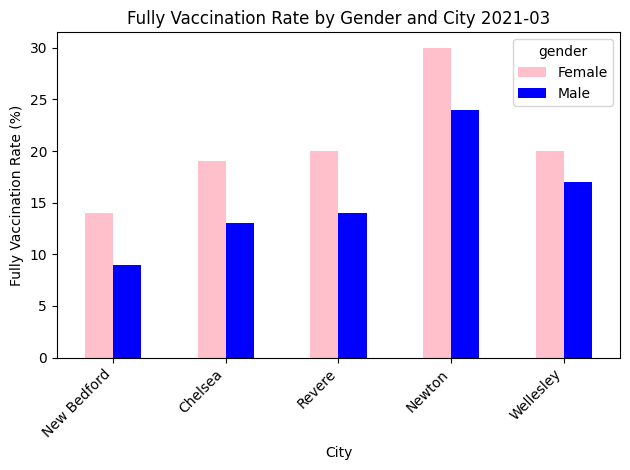

In [346]:
import matplotlib.pyplot as plt

city_order = ["New Bedford", "Chelsea", "Revere", "Newton", "Wellesley"]
selected_columns_2021_03['city'] = pd.Categorical(selected_columns_2021_03['city'], categories=city_order, ordered=True)
selected_columns_2021_03 = selected_columns_2021_03.sort_values('city')

# Pivoting the data for better visualization
pivot_df = selected_columns_2021_03.pivot(index='city', columns='gender', values='fully_vac_rate')

# Plotting
plt.figure(figsize=(8, 6))
pivot_df.plot(kind='bar', color=['pink', 'blue'], title="Fully Vaccination Rate by Gender and City 2021-03")
plt.xticks(rotation=45, ha='right')
plt.ylabel('Fully Vaccination Rate (%)')
plt.xlabel('City')
plt.tight_layout()
plt.show()


In [327]:
selected_columns_2023_03 = monthly_data_filled[
    (monthly_data_filled['year_month'] == "2023-03")
][['city', 'fully_vac_rate', 'gender', 'year_month']]

# Display the selected columns
print(selected_columns_2023_03)

            city  fully_vac_rate  gender year_month
480      Chelsea            86.0  Female    2023-03
481      Chelsea            78.0    Male    2023-03
484  New Bedford            63.0  Female    2023-03
485  New Bedford            59.0    Male    2023-03
488       Newton            98.0  Female    2023-03
489       Newton            97.0    Male    2023-03
492       Revere            81.0  Female    2023-03
493       Revere            76.0    Male    2023-03
496    Wellesley            82.0  Female    2023-03
497    Wellesley            88.0    Male    2023-03


<Figure size 800x600 with 0 Axes>

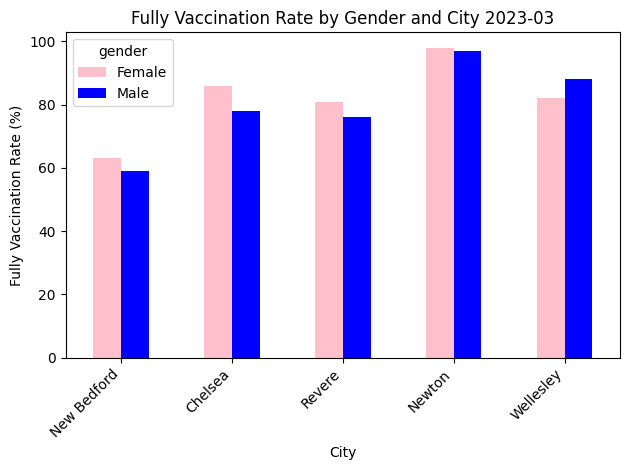

In [329]:
import matplotlib.pyplot as plt

city_order = ["New Bedford", "Chelsea", "Revere", "Newton", "Wellesley"]
selected_columns_2023_03['city'] = pd.Categorical(selected_columns_2023_04['city'], categories=city_order, ordered=True)
selected_columns_2023_03 = selected_columns_2023_03.sort_values('city')

# Pivoting the data for better visualization
pivot_df = selected_columns_2023_03.pivot(index='city', columns='gender', values='fully_vac_rate')

# Plotting
plt.figure(figsize=(8, 6))
pivot_df.plot(kind='bar', color=['pink', 'blue'], title="Fully Vaccination Rate by Gender and City 2023-03")
plt.xticks(rotation=45, ha='right')
plt.ylabel('Fully Vaccination Rate (%)')
plt.xlabel('City')
plt.tight_layout()
plt.show()



In [286]:
#save to the csv file
monthly_data_filled.to_csv('gender_monthly_data.csv', index=True)

In [284]:
# Calculate the average of vaccination rate by city and gender
average_vac_rate_by_city_gender = monthly_data_filled.groupby(['city', 'gender'])['fully_vac_rate'].mean()

average_vac_rate_by_city_gender

# # Plotting
# plt.figure(figsize=(8, 6))
# pivot_df.plot(kind='bar', color=['pink', 'blue'], title="Fully Vaccinated by Gender and City")
# plt.xticks(rotation=45, ha='right')
# plt.ylabel('Fully Vaccinated Rate (%)')
# plt.xlabel('City')
# plt.tight_layout()
# plt.show()

city         gender
Chelsea      Female    76.346154
             Male      68.576923
New Bedford  Female    54.000000
             Male      49.307692
Newton       Female    83.080000
             Male      81.560000
Revere       Female    70.923077
             Male      66.269231
Wellesley    Female    70.384615
             Male      74.692308
Name: fully_vac_rate, dtype: float64

/var/folders/b1/s_2bdh751d7_gtrtwf3td9wc0000gn/T/ipykernel_72596/662019421.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='city', y='fully_vac_rate', hue='gender', data=monthly_data_filled,


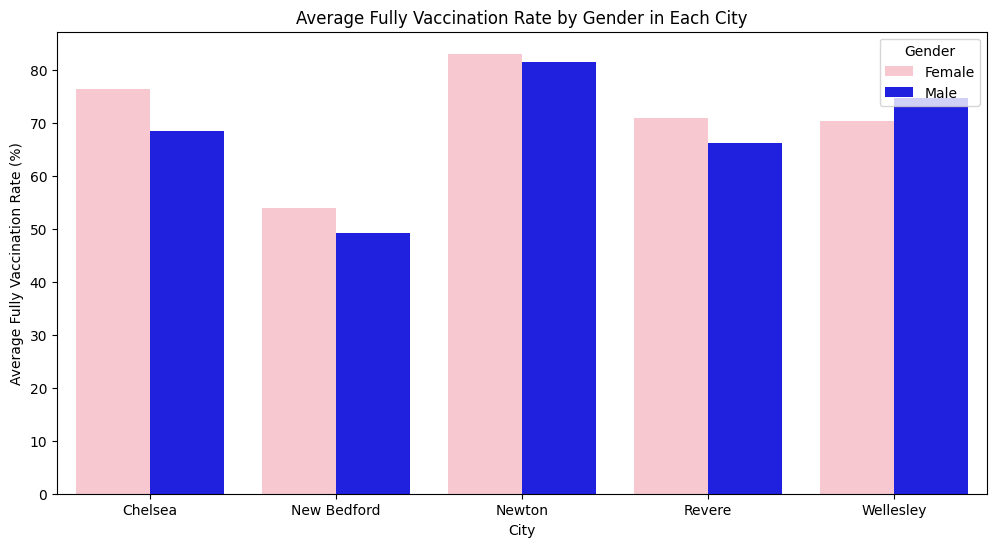

In [289]:
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a bar plot for the average vaccination rate by gender in each city
plt.figure(figsize=(12, 6))
sns.barplot(x='city', y='fully_vac_rate', hue='gender', data=monthly_data_filled, 
            estimator=np.mean, ci=None, palette={'Male': 'blue', 'Female': 'pink'})

plt.title('Average Fully Vaccination Rate by Gender in Each City')
plt.xlabel('City')
plt.ylabel('Average Fully Vaccination Rate (%)')
plt.legend(title='Gender')
plt.show()


/var/folders/b1/s_2bdh751d7_gtrtwf3td9wc0000gn/T/ipykernel_72596/2465496533.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data= monthly_data_filled, x='year_month', y='fully_vac_rate', hue='gender', marker='o', ci=None, palette=palette)


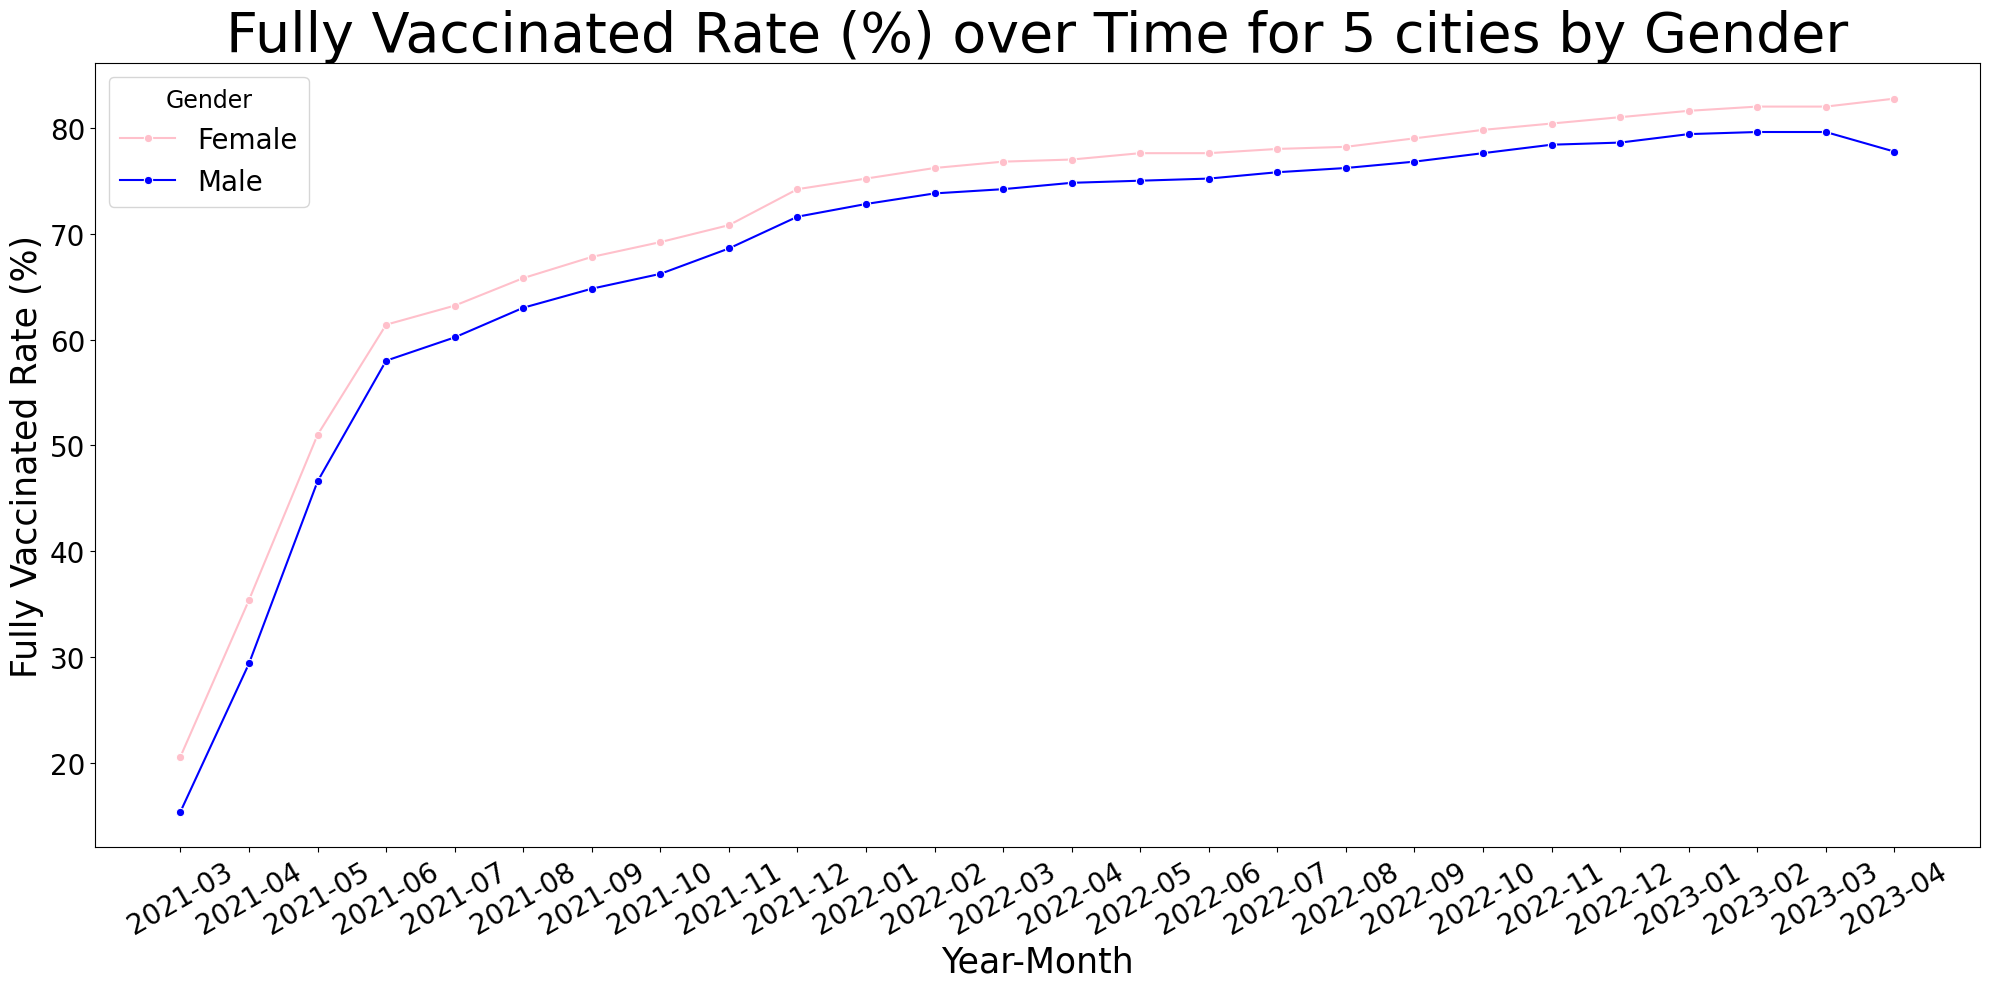

In [353]:
# Plotting fully_vac rate
plt.figure(figsize=(20, 10))
#sns.lineplot(data=df_filtered, x='date', y='vaccination_rate', hue='city', style='race')
monthly_data_filled['year_month'] = monthly_data_filled['year_month'].astype(str)

palette = {"Male": "blue", "Female": "pink"}
sns.lineplot(data= monthly_data_filled, x='year_month', y='fully_vac_rate', hue='gender', marker='o', ci=None, palette=palette)

# Adjusting x-axis for better readability

plt.xticks(rotation=30)

# Set title and labels
plt.title('Fully Vaccinated Rate (%) over Time for 5 cities by Gender', fontsize = 40)
plt.ylabel('Fully Vaccinated Rate (%)', fontsize = 25)
plt.xlabel('Year-Month', fontsize = 25)

# adjust the tick labels and legend
plt.xticks(rotation = 30, fontsize =20)
plt.yticks(fontsize = 20)
plt.legend(title='Gender', title_fontsize = '17', fontsize = 20, loc = 'upper left')


plt.tight_layout()


plt.savefig('./fully_vac_by_gender.png')

plt.show()

# Thanks Claire! Code stops here!

In [246]:
import statsmodels.formula.api as smf
# Constructing the linear regression model
monthly_data_filled['gender'] = pd.Categorical(monthly_data_filled['gender'], categories=['Male', 'Female'], ordered=True)

formula = 'fully_vac_rate ~ gender + city'
model = smf.ols(formula, data=monthly_data_filled).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         fully_vac_rate   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     21.63
Date:                Mon, 27 Nov 2023   Prob (F-statistic):           5.27e-18
Time:                        12:46:30   Log-Likelihood:                -1071.7
No. Observations:                 258   AIC:                             2155.
Df Residuals:                     252   BIC:                             2177.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              71.0236    

In [248]:
female_population = monthly_data_filled[monthly_data_filled['gender'] == 'Female'][['year', 'month', 'city', 'population']]

# Step 2: Group by 'year', 'month', and 'city' to get the total female population
female_population_grouped = female_population.groupby(['year', 'month', 'city']).sum().reset_index()

# Step 3: Merge this grouped data back into the original DataFrame
new_df = monthly_data_filled.merge(female_population_grouped, on=['year', 'month', 'city'], how='left', suffixes=('', '_female'))


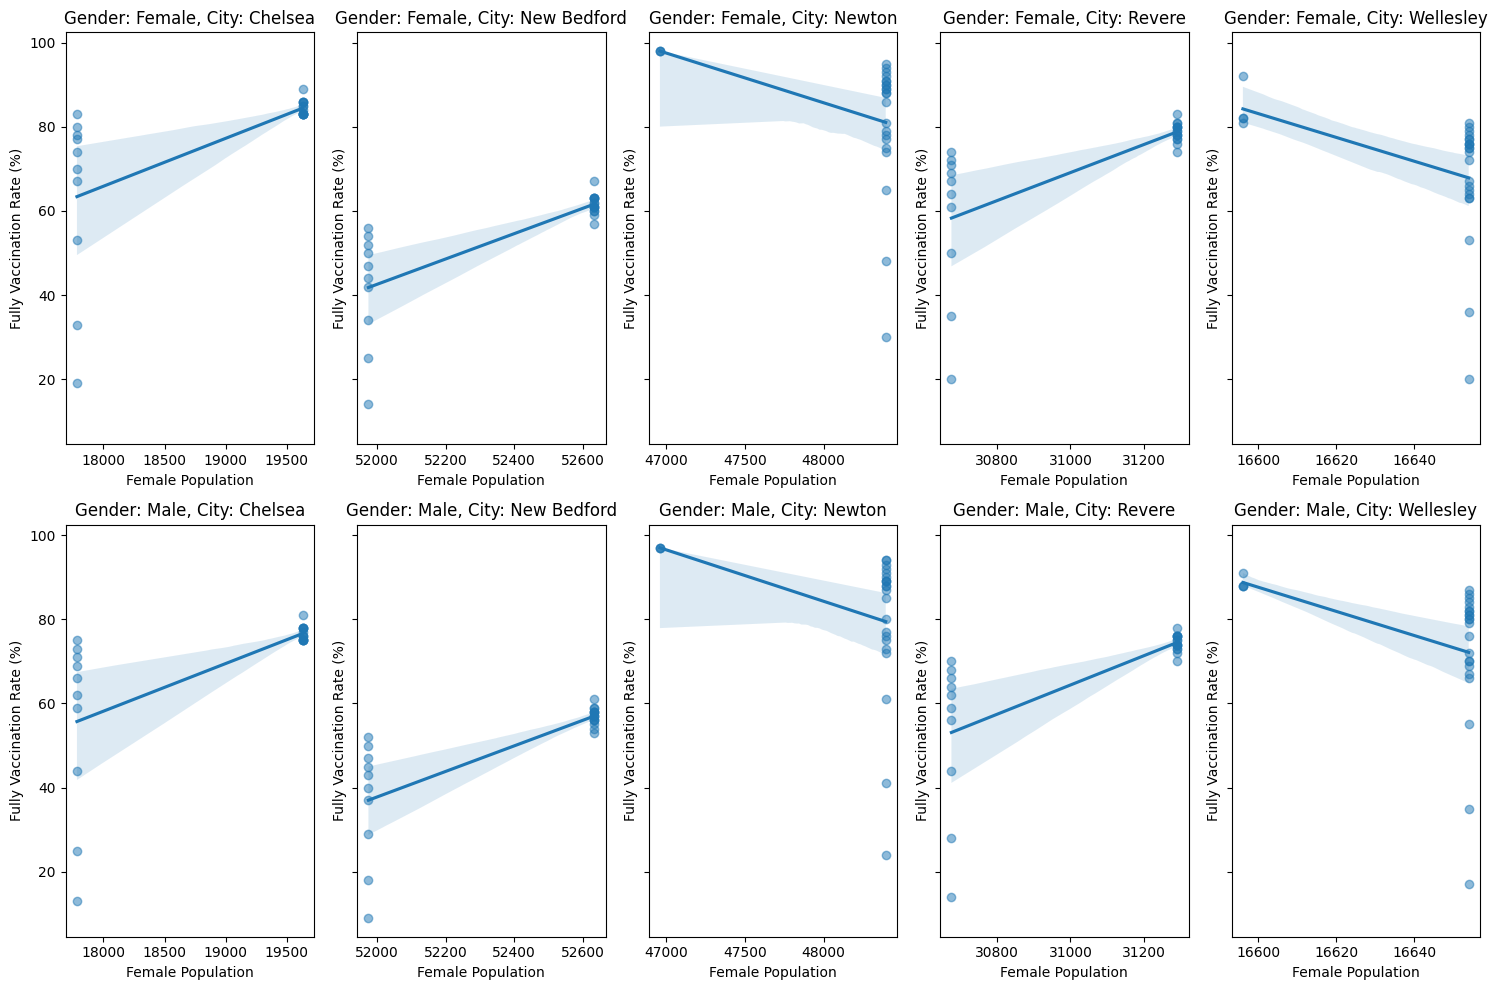

In [249]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'population_female' is a numeric predictor in your model
# and 'monthly_data_filled' is your DataFrame

# Unique categories of 'gender' and 'city'
genders = new_df['gender'].unique()
cities = new_df['city'].unique()

# Plotting
fig, axes = plt.subplots(len(genders), len(cities), figsize=(15, 10), sharey=True)

for i, gender in enumerate(genders):
    for j, city in enumerate(cities):
        ax = axes[i, j]
        subset = new_df[(new_df['gender'] == gender) & (new_df['city'] == city)]
        
        sns.regplot(
            x='population_female', 
            y='fully_vac_rate', 
            data=subset, 
            ax=ax,
            scatter_kws={'alpha': 0.5}
        )
        
        ax.set_title(f'Gender: {gender}, City: {city}')
        ax.set_xlabel('Female Population')
        ax.set_ylabel('Fully Vaccination Rate (%)')

plt.tight_layout()
plt.show()


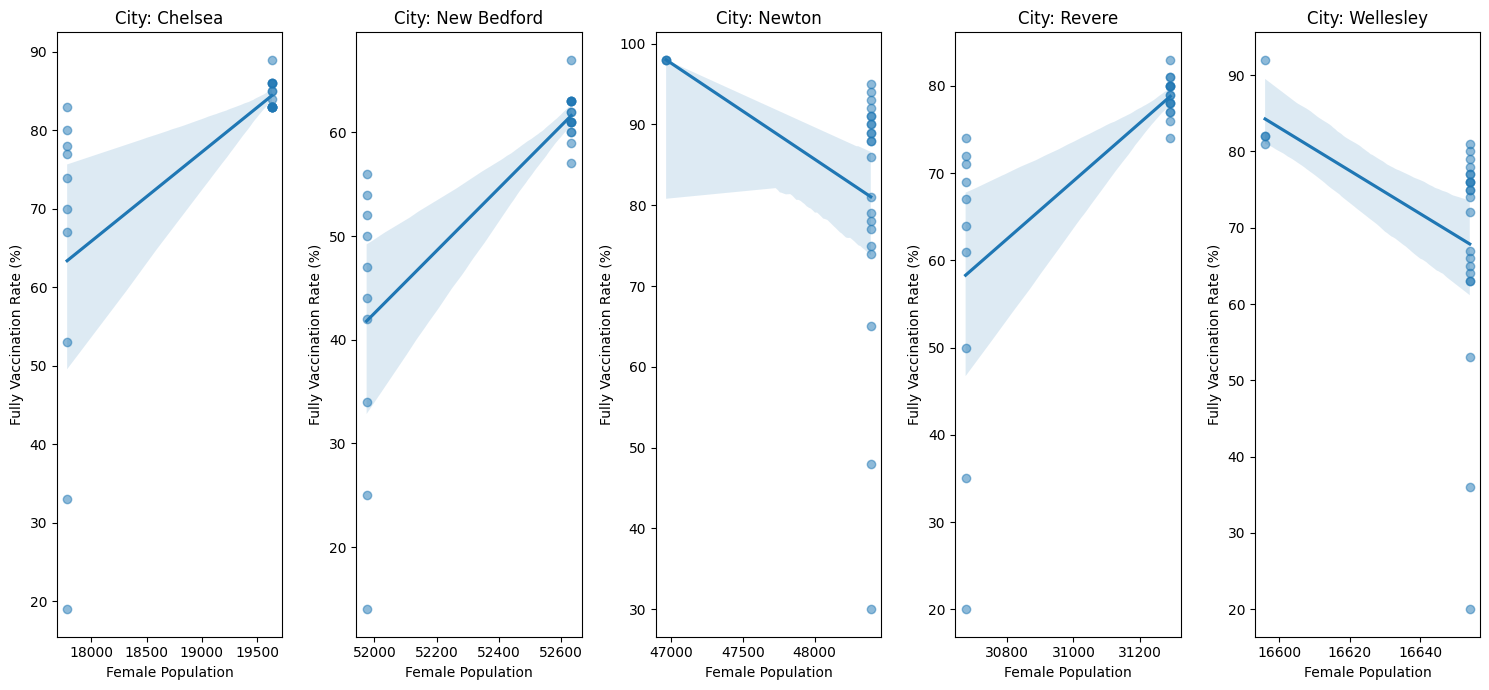

In [255]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data for females
female_data = new_df[new_df['gender'] == 'Female']

# Get unique cities
cities = female_data['city'].unique()

# Plotting
plt.figure(figsize=(15, 7))  # Adjust the figure size as needed

for i, city in enumerate(cities):
    plt.subplot(1, len(cities), i + 1)  # Create a subplot for each city
    sns.regplot(
        x='population_female',  # Replace with your predictor variable name
        y='fully_vac_rate', 
        data=female_data[female_data['city'] == city],
        scatter_kws={'alpha': 0.5}
    )
    plt.title(f'City: {city}')
    plt.xlabel('Female Population')  # Replace with your predictor variable name
    plt.ylabel('Fully Vaccination Rate (%)')

plt.tight_layout()
plt.show()


In [215]:
new_data = monthly_data.drop_duplicates(subset=['city', 'population', 'gender'])

# chelsea_data = monthly_data[monthly_data['city'] == 'Chelsea']
# print(chelsea_data)

newton_data = newton_data[newton_data['city'] == 'Newton']
newton_data


,year,month,city,gender,county,population,atleast_onedose,fully_vaccinated,boosted_after_2022-09-01,boosted,boosted_second,partially_vaccinated,fully_vac_rate,partially_vac_rate,onedose_vac_rate,boosted_rate,year_month
8,2021,3,Newton,Female,Middlesex,48393.0,22261.0,14345.0,NaN,NaN,NaN,7916.0,30.0,16.0,46.0,NaN,2021-03
9,2021,3,Newton,Male,Middlesex,43297.0,16640.0,10295.0,NaN,NaN,NaN,6345.0,24.0,15.0,38.0,NaN,2021-03
28,2021,4,Newton,Female,Middlesex,48393.0,32920.0,23123.0,NaN,NaN,NaN,10028.0,48.0,21.0,68.0,NaN,2021-04
29,2021,4,Newton,Male,Middlesex,43297.0,27395.0,17881.0,NaN,NaN,NaN,9550.0,41.0,22.0,63.0,NaN,2021-04
48,2021,5,Newton,Female,Middlesex,48393.0,37502.0,31368.0,NaN,NaN,NaN,9027.0,65.0,19.0,77.0,NaN,2021-05
49,2021,5,Newton,Male,Middlesex,43297.0,32233.0,26339.0,NaN,NaN,NaN,8998.0,61.0,21.0,74.0,NaN,2021-05
68,2021,6,Newton,Female,Middlesex,48393.0,39121.0,35805.0,NaN,NaN,NaN,5751.0,74.0,12.0,81.0,NaN,2021-06
69,2021,6,Newton,Male,Middlesex,43297.0,33996.0,31081.0,NaN,NaN,NaN,5388.0,72.0,12.0,79.0,NaN,2021-06
88,2021,7,Newton,Female,Middlesex,48393.0,39657.0,36369.0,NaN,NaN,NaN,3296.0,75.0,7.0,82.0,NaN,2021-07
89,2021,7,Newton,Male,Middlesex,43297.0,34467.0,31627.0,NaN,NaN,NaN,2872.0,73.0,7.0,80.0,NaN,2021-07


In [227]:
import pandas as pd

# Assuming df is your DataFrame
# Step 1: Filter for female population
female_population = new_data[new_data['gender'] == 'Female'][['year', 'month', 'city', 'population']]

# Step 2: Group by 'year', 'month', and 'city' to get the total female population
female_population_grouped = female_population.groupby(['year', 'month', 'city']).sum().reset_index()

# Step 3: Merge this grouped data back into the original DataFrame
new_df = newton_data.merge(female_population_grouped, on=['year', 'month', 'city'], how='left', suffixes=('', '_female'))

# Now df has an additional column 'population_female' with the female population for each city and month

KeyError: 'city'

In [228]:
new_df.shape

(52, 18)

In [225]:
new_df

,year,month,city,gender,county,population,atleast_onedose,fully_vaccinated,boosted_after_2022-09-01,boosted,boosted_second,partially_vaccinated,fully_vac_rate,partially_vac_rate,onedose_vac_rate,boosted_rate,year_month,population_female
0,2021,3,Newton,Female,Middlesex,48393.0,22261.0,14345.0,NaN,NaN,NaN,7916.0,30.0,16.0,46.0,NaN,2021-03,48393.0
1,2021,3,Newton,Male,Middlesex,43297.0,16640.0,10295.0,NaN,NaN,NaN,6345.0,24.0,15.0,38.0,NaN,2021-03,48393.0
2,2021,4,Newton,Female,Middlesex,48393.0,32920.0,23123.0,NaN,NaN,NaN,10028.0,48.0,21.0,68.0,NaN,2021-04,NaN
3,2021,4,Newton,Male,Middlesex,43297.0,27395.0,17881.0,NaN,NaN,NaN,9550.0,41.0,22.0,63.0,NaN,2021-04,NaN
4,2021,5,Newton,Female,Middlesex,48393.0,37502.0,31368.0,NaN,NaN,NaN,9027.0,65.0,19.0,77.0,NaN,2021-05,NaN
5,2021,5,Newton,Male,Middlesex,43297.0,32233.0,26339.0,NaN,NaN,NaN,8998.0,61.0,21.0,74.0,NaN,2021-05,NaN
6,2021,6,Newton,Female,Middlesex,48393.0,39121.0,35805.0,NaN,NaN,NaN,5751.0,74.0,12.0,81.0,NaN,2021-06,NaN
7,2021,6,Newton,Male,Middlesex,43297.0,33996.0,31081.0,NaN,NaN,NaN,5388.0,72.0,12.0,79.0,NaN,2021-06,NaN
8,2021,7,Newton,Female,Middlesex,48393.0,39657.0,36369.0,NaN,NaN,NaN,3296.0,75.0,7.0,82.0,NaN,2021-07,NaN
9,2021,7,Newton,Male,Middlesex,43297.0,34467.0,31627.0,NaN,NaN,NaN,2872.0,73.0,7.0,80.0,NaN,2021-07,NaN


In [226]:
import statsmodels.api as sm

# Assuming df is your DataFrame and it already contains a 'population_female' column
# Prepare the data
X = new_df['population_female']  # Predictor
y = new_df['fully_vac_rate']     # Response

# Add a constant to the model (the intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

plt.scatter(new_df['population_female'], new_df['fully_vac_rate'], alpha=0.7, label='Data points')


# Regression line
predicted_values = model.predict(X)
plt.plot(new_df['population_female'], predicted_values, color='red', label='Regression Line')

# Plot details
plt.xlabel('Female Population')
plt.ylabel('Fully Vaccination Rate (%)')
plt.title('Linear Regression: Vaccination Rate vs Female Population')
plt.legend()
plt.show()

# Check the results
summary = model.summary()

print(summary)

MissingDataError: exog contains inf or nans

In [175]:
import pandas as pd

# Assuming df is your DataFrame
# Step 1: Filter for female population
female_population = monthly_data[monthly_data['gender'] == 'Female'][['year', 'month', 'city', 'population']]

# Step 2: Group by 'year', 'month', and 'city' to get the total female population
female_population_grouped = female_population.groupby(['year', 'month', 'city']).sum().reset_index()

# Step 3: Merge this grouped data back into the original DataFrame
df = monthly_data.merge(female_population_grouped, on=['year', 'month', 'city'], how='left', suffixes=('', '_female'))

# Now df has an additional column 'population_female' with the female population for each city and month


In [176]:
df

,year,month,city,gender,county,population,atleast_onedose,fully_vaccinated,boosted_after_2022-09-01,boosted,boosted_second,partially_vaccinated,fully_vac_rate,partially_vac_rate,onedose_vac_rate,boosted_rate,year_month,population_female
0,2021,3,Chelsea,Female,Suffolk,17783.0,5311.0,3304.0,NaN,NaN,NaN,2007.0,19.0,11.0,30.0,NaN,2021-03,17783.0
1,2021,3,Chelsea,Male,Suffolk,19135.0,4120.0,2405.0,NaN,NaN,NaN,1715.0,13.0,9.0,22.0,NaN,2021-03,17783.0
2,2021,3,New Bedford,Female,Bristol,51975.0,12408.0,7463.0,NaN,NaN,NaN,4958.0,14.0,10.0,24.0,NaN,2021-03,51975.0
3,2021,3,New Bedford,Male,Bristol,48005.0,8093.0,4503.0,NaN,NaN,NaN,3601.0,9.0,8.0,17.0,NaN,2021-03,51975.0
4,2021,3,Newton,Female,Middlesex,48393.0,22261.0,14345.0,NaN,NaN,NaN,7916.0,30.0,16.0,46.0,NaN,2021-03,48393.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,2023,4,Newton,Male,Middlesex,41960.0,NaN,NaN,20556.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04,46963.0
256,2023,4,Revere,Female,Suffolk,31291.0,30157.0,26127.0,7118.0,NaN,NaN,NaN,83.0,NaN,96.0,NaN,2023-04,31291.0
257,2023,4,Revere,Male,Suffolk,30895.0,27967.0,24170.0,5745.0,NaN,NaN,NaN,78.0,NaN,91.0,NaN,2023-04,31291.0
258,2023,4,Wellesley,Female,Norfolk,16596.0,NaN,15315.0,7841.0,NaN,NaN,NaN,92.0,NaN,NaN,NaN,2023-04,16596.0


In [ ]:
import statsmodels.api as sm

# Constructing the linear regression model
formula = 'fully_vac_rate ~ race + city + boosted_rate'
model = smf.ols(formula, data=monthly_data_filled).fit()
# Encoding 'race' as a numerical value
#monthly_data['race_encoded'] = monthly_data['race'].astype('category').cat.codes

# Create a combined cluster variable
#monthly_data_filled['combined_cluster'] =  + "_" + 
print(model.summary())


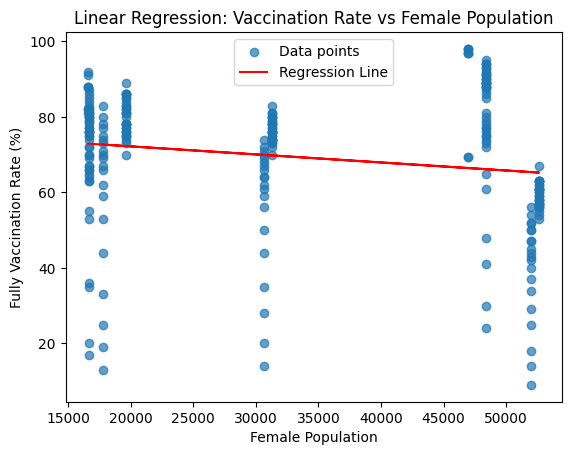

                            OLS Regression Results                            
Dep. Variable:         fully_vac_rate   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     7.729
Date:                Sun, 26 Nov 2023   Prob (F-statistic):            0.00583
Time:                        21:07:15   Log-Likelihood:                -1121.0
No. Observations:                 260   AIC:                             2246.
Df Residuals:                     258   BIC:                             2253.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                76.4425      2.79

In [141]:
import statsmodels.api as sm

# Assuming df is your DataFrame and it already contains a 'population_female' column
# Prepare the data
X = df['population_female']  # Predictor
y = df['fully_vac_rate']     # Response

# Add a constant to the model (the intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

plt.scatter(df['population_female'], df['fully_vac_rate'], alpha=0.7, label='Data points')


# Regression line
predicted_values = model.predict(X)
plt.plot(df['population_female'], predicted_values, color='red', label='Regression Line')

# Plot details
plt.xlabel('Female Population')
plt.ylabel('Fully Vaccination Rate (%)')
plt.title('Linear Regression: Vaccination Rate vs Female Population')
plt.legend()
plt.show()

# Check the results
summary = model.summary()

print(summary)

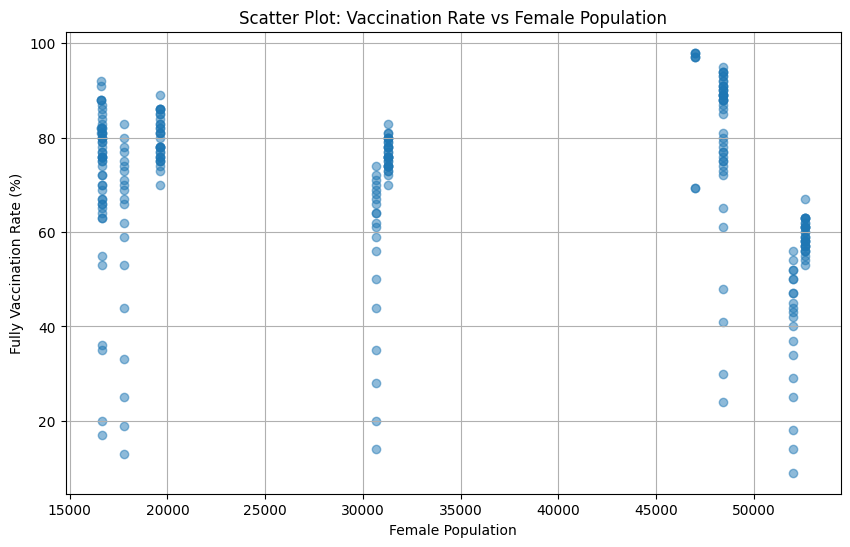

In [142]:
# Plotting the relationship without a regression model
plt.figure(figsize=(10, 6))
plt.scatter(df['population_female'], df['fully_vac_rate'], alpha=0.5)

# Plot details
plt.xlabel('Female Population')
plt.ylabel('Fully Vaccination Rate (%)')
plt.title('Scatter Plot: Vaccination Rate vs Female Population')
plt.grid(True)
plt.show()

Missing values: year                          0
month                         0
city                          0
gender                        0
county                        0
population                    0
atleast_onedose              41
fully_vaccinated              2
boosted_after_2022-09-01    250
boosted                     100
boosted_second              170
partially_vaccinated         90
fully_vac_rate                2
partially_vac_rate           90
onedose_vac_rate             41
boosted_rate                100
year_month                    0
dtype: int64


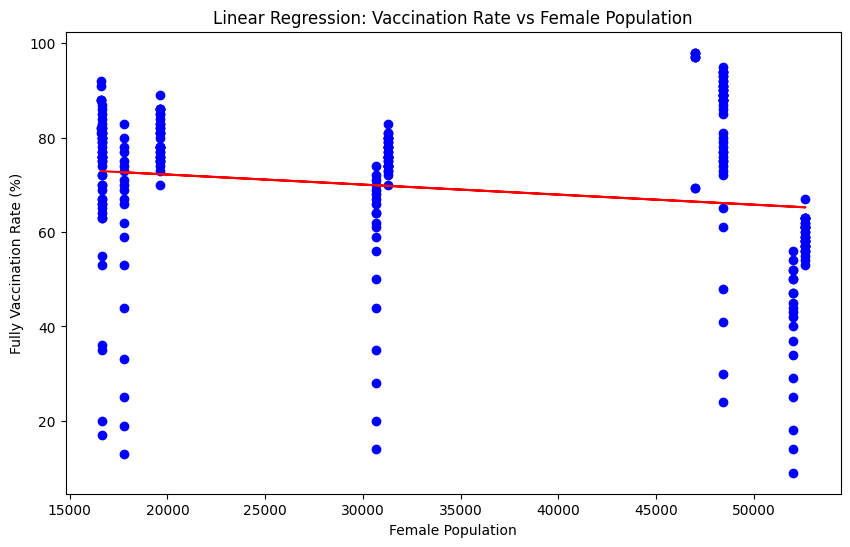

(-0.0002128600497607239, 76.44245891599874)

In [137]:

# Imputing missing values with the mean
df['fully_vac_rate'].fillna(df['fully_vac_rate'].mean(), inplace=True)

# Check for missing values
print("Missing values:", monthly_data.isnull().sum())

# Reshaping the predictor variable for use in LinearRegression
X = df[['population_female']]  # Needs to be in 2D array format
y = df['fully_vac_rate']

# Setting up linear regression model
model = LinearRegression()
model.fit(X, y)

# Getting the slope (coefficient) and the intercept
slope = model.coef_[0]
intercept = model.intercept_

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(df['population_female'], y, color='blue')
plt.plot(df['population_female'], model.predict(X), color='red')
plt.xlabel('Female Population')
plt.ylabel('Fully Vaccination Rate (%)')
plt.title('Linear Regression: Vaccination Rate vs Female Population')
plt.show()

(slope, intercept)

In [165]:
import pandas as pd

# Assuming df is your DataFrame
# Step 1: Filter for female population
female_population = population_df[population_df['gender'] == 'Female'][['year', 'month', 'city', 'population']]

# Step 2: Group by 'year', 'month', and 'city' to get the total female population
female_population_grouped = female_population.groupby(['year', 'month', 'city']).sum().reset_index()

# Step 3: Merge this grouped data back into the original DataFrame
merged_df = population_df.merge(female_population_grouped, on=['year', 'month', 'city'], how='left', suffixes=('', '_female'))

In [171]:
# 3. calculate the vaccination rate
# Calculating vaccination rate
merged_df['fully_vac_rate'] = round((merged_df['fully_vaccinated'] / merged_df['population']),2) * 100
merged_df['partially_vac_rate'] = round((merged_df['partially_vaccinated'] / merged_df['population']),2) * 100
merged_df['onedose_vac_rate'] = round((merged_df['atleast_onedose'] / merged_df['population']),2) * 100
merged_df['boosted_rate'] = round((merged_df['boosted'] / merged_df['population']),2) * 100


# exclued data of 'Other/Unknown' in race
merged_df = merged_df[~merged_df['gender'].isin(['Other'])]

# exclued data of 'NH/PI' in race
merged_df = merged_df[~merged_df['gender'].isin(['Total'])]

In [172]:
merged_df

,date,county,city,gender,population,atleast_onedose,fully_vaccinated,boosted_after_2022-09-01,boosted,boosted_second,partially_vaccinated,fully_vac_rate,partially_vac_rate,onedose_vac_rate,boosted_rate,year,month,year_month,population_female
0,2021-03-09,Bristol,New Bedford,Female,51975.0,8901.0,4421.0,NaN,NaN,NaN,4480.0,9.0,9.0,17.0,NaN,2021,3,2021-03,51975.0
1,2021-03-09,Bristol,New Bedford,Male,48005.0,5468.0,2242.0,NaN,NaN,NaN,3226.0,5.0,7.0,11.0,NaN,2021,3,2021-03,51975.0
2,2021-03-09,Middlesex,Newton,Female,48393.0,15783.0,9268.0,NaN,NaN,NaN,6515.0,19.0,13.0,33.0,NaN,2021,3,2021-03,48393.0
3,2021-03-09,Middlesex,Newton,Male,43297.0,11400.0,6245.0,NaN,NaN,NaN,5155.0,14.0,12.0,26.0,NaN,2021,3,2021-03,48393.0
4,2021-03-09,Norfolk,Wellesley,Female,16654.0,3642.0,2010.0,NaN,NaN,NaN,1632.0,12.0,10.0,22.0,NaN,2021,3,2021-03,16654.0
5,2021-03-09,Norfolk,Wellesley,Male,13059.0,2631.0,1293.0,NaN,NaN,NaN,1338.0,10.0,10.0,20.0,NaN,2021,3,2021-03,16654.0
6,2021-03-09,Suffolk,Chelsea,Female,17783.0,3526.0,2035.0,NaN,NaN,NaN,1491.0,11.0,8.0,20.0,NaN,2021,3,2021-03,17783.0
7,2021-03-09,Suffolk,Chelsea,Male,19135.0,2651.0,1346.0,NaN,NaN,NaN,1305.0,7.0,7.0,14.0,NaN,2021,3,2021-03,17783.0
8,2021-03-09,Suffolk,Revere,Female,30676.0,6295.0,3509.0,NaN,NaN,NaN,2786.0,11.0,9.0,21.0,NaN,2021,3,2021-03,30676.0
9,2021-03-09,Suffolk,Revere,Male,30173.0,4493.0,2175.0,NaN,NaN,NaN,2318.0,7.0,8.0,15.0,NaN,2021,3,2021-03,30676.0


In [173]:
len(merged_df)

20

Missing values: date                         0
county                       0
city                         0
gender                       0
population                   0
atleast_onedose              3
fully_vaccinated             0
boosted_after_2022-09-01    20
boosted                     10
boosted_second              16
partially_vaccinated         4
fully_vac_rate               0
partially_vac_rate           4
onedose_vac_rate             3
boosted_rate                10
year                         0
month                        0
year_month                   0
population_female            0
dtype: int64


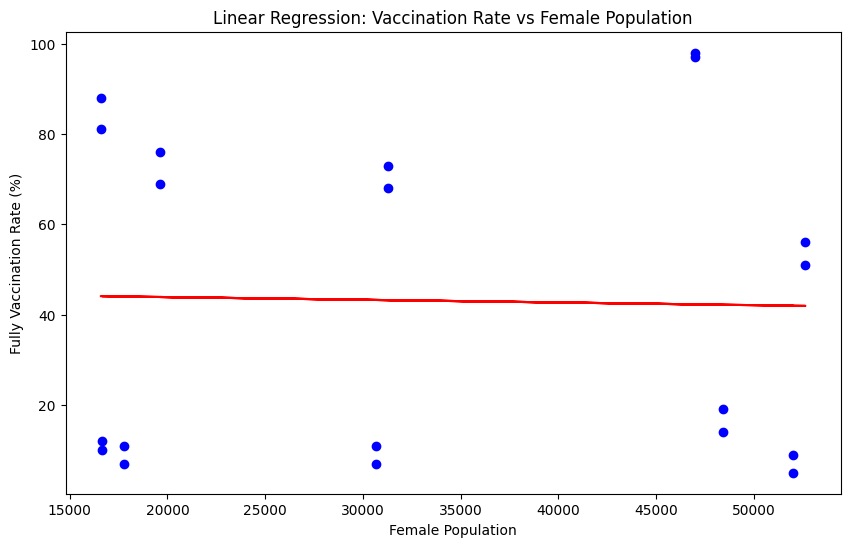

(-5.9497561810891445e-05, 45.078859157049344)

In [174]:

# Imputing missing values with the mean
merged_df['fully_vac_rate'].fillna(merged_df['fully_vac_rate'].mean(), inplace=True)

# Check for missing values
print("Missing values:", merged_df.isnull().sum())

# Reshaping the predictor variable for use in LinearRegression
X = merged_df[['population_female']]  # Needs to be in 2D array format
y = merged_df['fully_vac_rate']

# Setting up linear regression model
model = LinearRegression()
model.fit(X, y)

# Getting the slope (coefficient) and the intercept
slope = model.coef_[0]
intercept = model.intercept_

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['population_female'], y, color='blue')
plt.plot(merged_df['population_female'], model.predict(X), color='red')
plt.xlabel('Female Population')
plt.ylabel('Fully Vaccination Rate (%)')
plt.title('Linear Regression: Vaccination Rate vs Female Population')
plt.show()

(slope, intercept)

In [164]:
population_df = vac_data[vac_data['gender'].isin(['Female', 'Male',])]
print(population_df.shape)
population_df = population_df.drop_duplicates(subset=['city', 'population'])
print(len(population_df))
population_df

(1110, 18)
20


,date,county,city,gender,population,atleast_onedose,fully_vaccinated,boosted_after_2022-09-01,boosted,boosted_second,partially_vaccinated,fully_vac_rate,partially_vac_rate,onedose_vac_rate,boosted_rate,year,month,year_month
200,2021-03-09,Bristol,New Bedford,Female,51975.0,8901.0,4421.0,NaN,NaN,NaN,4480.0,9.0,9.0,17.0,NaN,2021,3,2021-03
201,2021-03-09,Bristol,New Bedford,Male,48005.0,5468.0,2242.0,NaN,NaN,NaN,3226.0,5.0,7.0,11.0,NaN,2021,3,2021-03
780,2021-03-09,Middlesex,Newton,Female,48393.0,15783.0,9268.0,NaN,NaN,NaN,6515.0,19.0,13.0,33.0,NaN,2021,3,2021-03
781,2021-03-09,Middlesex,Newton,Male,43297.0,11400.0,6245.0,NaN,NaN,NaN,5155.0,14.0,12.0,26.0,NaN,2021,3,2021-03
968,2021-03-09,Norfolk,Wellesley,Female,16654.0,3642.0,2010.0,NaN,NaN,NaN,1632.0,12.0,10.0,22.0,NaN,2021,3,2021-03
969,2021-03-09,Norfolk,Wellesley,Male,13059.0,2631.0,1293.0,NaN,NaN,NaN,1338.0,10.0,10.0,20.0,NaN,2021,3,2021-03
1096,2021-03-09,Suffolk,Chelsea,Female,17783.0,3526.0,2035.0,NaN,NaN,NaN,1491.0,11.0,8.0,20.0,NaN,2021,3,2021-03
1097,2021-03-09,Suffolk,Chelsea,Male,19135.0,2651.0,1346.0,NaN,NaN,NaN,1305.0,7.0,7.0,14.0,NaN,2021,3,2021-03
1100,2021-03-09,Suffolk,Revere,Female,30676.0,6295.0,3509.0,NaN,NaN,NaN,2786.0,11.0,9.0,21.0,NaN,2021,3,2021-03
1101,2021-03-09,Suffolk,Revere,Male,30173.0,4493.0,2175.0,NaN,NaN,NaN,2318.0,7.0,8.0,15.0,NaN,2021,3,2021-03


In [169]:

# Imputing missing values with the mean
population_df['fully_vac_rate'].fillna(population_df['fully_vac_rate'].mean(), inplace=True)

# Check for missing values
print("Missing values:", population_df.isnull().sum())

# Reshaping the predictor variable for use in LinearRegression
X = population_df[['female_population']]  # Needs to be in 2D array format
y = population_df['fully_vac_rate']

# Setting up linear regression model
model = LinearRegression()
model.fit(X, y)

# Getting the slope (coefficient) and the intercept
slope = model.coef_[0]
intercept = model.intercept_

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(population_df['female_population'], y, color='blue')
plt.plot(population_df['female_population'], model.predict(X), color='red')
plt.xlabel('Female Population')
plt.ylabel('Fully Vaccination Rate (%)')
plt.title('Linear Regression: Vaccination Rate vs Female Population')
plt.show()

(slope, intercept)

Missing values: date                         0
county                       0
city                         0
gender                       0
population                   0
atleast_onedose              3
fully_vaccinated             0
boosted_after_2022-09-01    20
boosted                     10
boosted_second              16
partially_vaccinated         4
fully_vac_rate               0
partially_vac_rate           4
onedose_vac_rate             0
boosted_rate                10
year                         0
month                        0
year_month                   0
dtype: int64


KeyError: "None of [Index(['female_population'], dtype='object')] are in the [columns]"

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


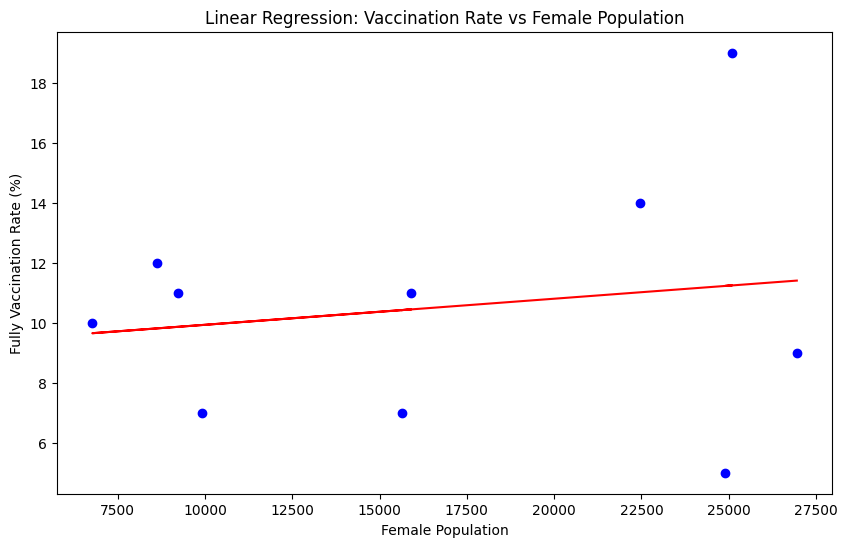

((8.694451563343497e-05, 9.061233460846353),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:         fully_vac_rate   R-squared:                       0.028
 Model:                            OLS   Adj. R-squared:                 -0.093
 Method:                 Least Squares   F-statistic:                    0.2337
 Date:                Sun, 26 Nov 2023   Prob (F-statistic):              0.642
 Time:                        15:49:17   Log-Likelihood:                -27.399
 No. Observations:                  10   AIC:                             58.80
 Df Residuals:                       8   BIC:                             59.40
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
 -----------------

In [91]:
import statsmodels.api as sm

# Reshaping the predictor variable for use in OLS
X = population_df[['female_population']]  # Needs to be in 2D array format
X = sm.add_constant(X)  # adding a constant
y = population_df['fully_vac_rate']

# Setting up OLS regression model
model = sm.OLS(y, X).fit()

# Summary of the model
model_summary = model.summary()

# Getting the slope (coefficient) and the intercept from the model
slope = model.params['female_population']
intercept = model.params['const']

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(population_df['female_population'], y, color='blue')
plt.plot(population_df['female_population'], model.predict(X), color='red')
plt.xlabel('Female Population')
plt.ylabel('Fully Vaccination Rate (%)')
plt.title('Linear Regression: Vaccination Rate vs Female Population')
plt.show()

(slope, intercept), model_summary

In [92]:
print(len(population_df['female_population']))

10


In [15]:
# List of cities of interest
cities_of_interest = ['Revere', 'Chelsea', 'Newton', 'Wellesley', 'New Bedford']

# Filtering the DataFrame for the cities of interest and relevant genders
filtered_df = vac_data[(vac_data['city'].isin(cities_of_interest)) & df['gender'].isin(['Female', 'Male'])]

# Grouping by city and gender, then summing up the fully vaccinated numbers
comparison_df = filtered_df.groupby(['city', 'gender'])['fully_vaccinated'].sum().unstack()

comparison_df

/var/folders/b1/s_2bdh751d7_gtrtwf3td9wc0000gn/T/ipykernel_72596/1733557782.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = vac_data[(vac_data['city'].isin(cities_of_interest)) & df['gender'].isin(['Female', 'Male'])]


gender,Female,Male
city,,
Chelsea,1579954.0,1534457.0
New Bedford,3098428.0,2607583.0
Newton,4281813.0,3753654.0
Revere,2419010.0,2223987.0
Wellesley,1283556.0,1066692.0


In [32]:
# List of cities of interest
cities_of_interest = ['Revere', 'Chelsea', 'Newton', 'Wellesley', 'New Bedford']

# Filtering the DataFrame for the cities of interest and relevant genders
filtered_df = vac_data[(vac_data['city'].isin(cities_of_interest)) & df['gender'].isin(['Female', 'Male'])]

# Grouping by city and gender, then summing up the fully vaccinated numbers
comparison_df = filtered_df.groupby(['city', 'gender'])['fully_vaccinated'].sum().unstack()

comparison_df

gender,Female,Male
city,,
Chelsea,1579954.0,1534457.0
New Bedford,3098428.0,2607583.0
Newton,4425744.0,3880319.0
Revere,2419010.0,2223987.0
Wellesley,1283556.0,1066692.0


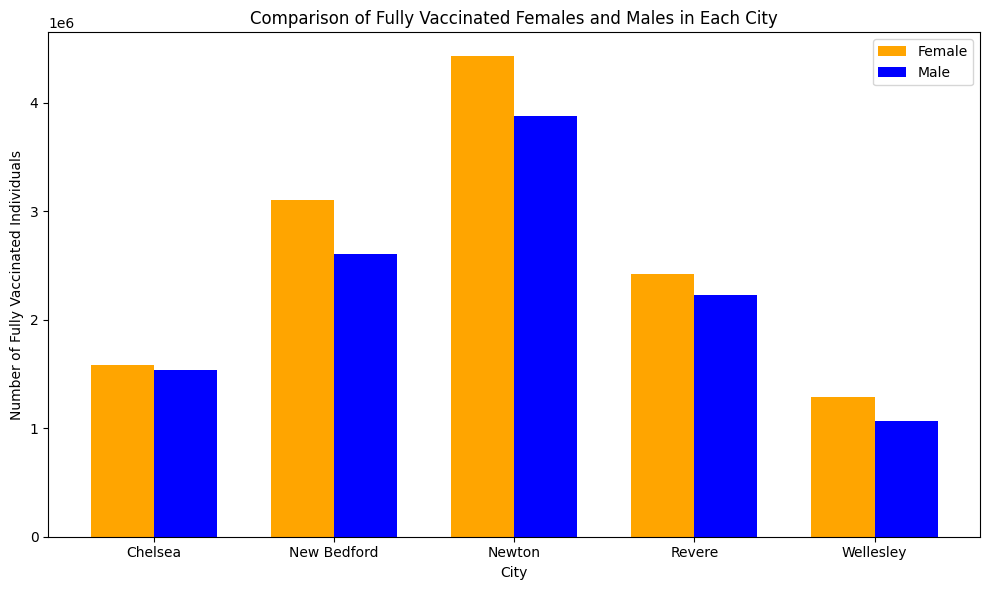

In [33]:
import numpy as np
plt.figure(figsize=(10, 6))

# Setting the positions for the bars
bar_width = 0.35
index = np.arange(len(comparison_df))

# Plotting the bars for females and males side by side for each city
bar1 = plt.bar(index, comparison_df['Female'], bar_width, label='Female', color='orange')
bar2 = plt.bar(index + bar_width, comparison_df['Male'], bar_width, label='Male', color='blue')

plt.xlabel('City')
plt.ylabel('Number of Fully Vaccinated Individuals')
plt.title('Comparison of Fully Vaccinated Females and Males in Each City')
plt.xticks(index + bar_width / 2, comparison_df.index)
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
# List of cities of interest
cities_of_interest = ['Revere', 'Chelsea', 'Newton', 'Wellesley', 'New Bedford']

# Filtering the DataFrame for the cities of interest and relevant genders
filtered_one_df = df[(df['city'].isin(cities_of_interest)) & df['gender'].isin(['Female', 'Male'])]

# Grouping by city and gender, then summing up the fully vaccinated numbers
comparison_one_df = filtered_df.groupby(['city', 'gender'])['atleast_onedose'].sum().unstack()

comparison_one_df

gender,Female,Male
city,,
Chelsea,1914063.0,1883738.0
New Bedford,3604223.0,3054006.0
Newton,5096012.0,4461039.0
Revere,2828375.0,2606032.0
Wellesley,1512182.0,1245017.0


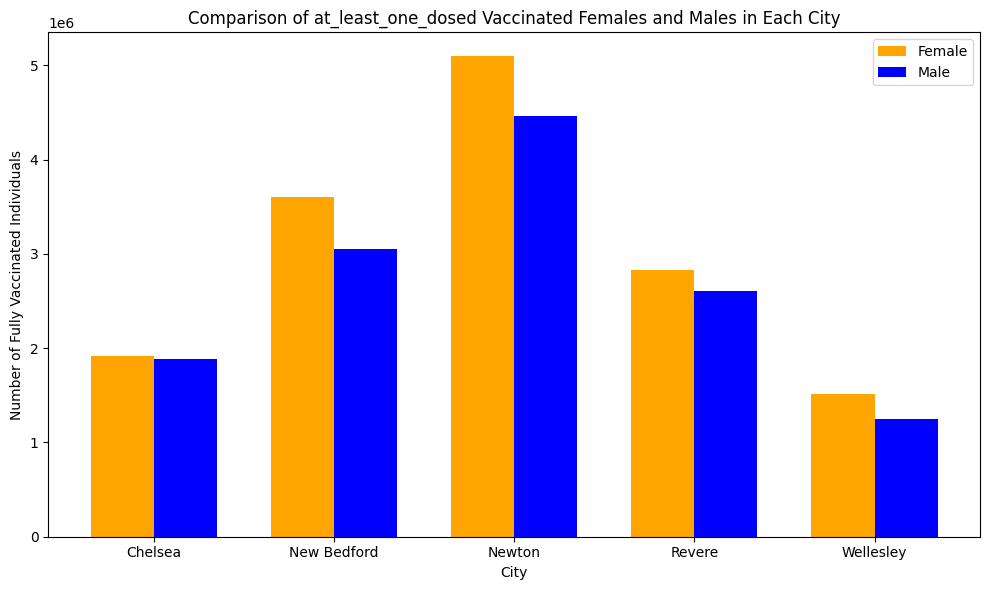

In [36]:
import numpy as np
plt.figure(figsize=(10, 6))

# Setting the positions for the bars
bar_width = 0.35
index = np.arange(len(comparison_one_df))

# Plotting the bars for females and males side by side for each city
bar1 = plt.bar(index, comparison_one_df['Female'], bar_width, label='Female', color='orange')
bar2 = plt.bar(index + bar_width, comparison_one_df['Male'], bar_width, label='Male', color='blue')

plt.xlabel('City')
plt.ylabel('Number of Fully Vaccinated Individuals')
plt.title('Comparison of at_least_one_dosed Vaccinated Females and Males in Each City')
plt.xticks(index + bar_width / 2, comparison_one_df.index)
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
# Create a DataFrame from the sample data
# df = pd.DataFrame(data)

# Group the data by 'City' and 'Gender' and calculate the sum of 'Fully_Vaccinated' for each group
result = df_cleaned.groupby(['city', 'gender'])['fully_vaccinated'].sum().unstack(fill_value=0)

# Print the result
print(result)

gender          Female       Male    Other      Total
city                                                 
Abington      678416.0   582480.0      0.0        0.0
Acton        1082475.0  1006237.0   2727.0  1292522.0
Acushnet      369096.0   322615.0      0.0        0.0
Adams         319248.0   274497.0      0.0        0.0
Agawam       1054273.0   868613.0   8334.0   471267.0
...                ...        ...      ...        ...
Woburn       1733750.0  1501737.0   4920.0  2071882.0
Worcester    6804754.0  5978610.0  25158.0  8369615.0
Worthington    45752.0    40211.0      0.0        0.0
Wrentham      512394.0   460000.0    931.0   201789.0
Yarmouth     1085288.0   852369.0      0.0        0.0

[339 rows x 4 columns]
